# Background: 
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

 

## Objective: 
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

## Data Description: 
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call.

    Customer key - Identifier for the customer
    Average Credit Limit - Average credit limit across all the credit cards
    Total credit cards - Total number of credit cards
    Total visits bank - Total number of bank visits
    Total visits online - total number of online visits
    Total calls made - Total number of calls made by the customer

In [173]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 

from scipy.stats import zscore
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

#import sklearn.metrics

CC_data_df = pd.read_excel('Credit Card Customer Data.xlsx')
CC_data_df.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [174]:
CC_data_df.shape

(660, 7)

In [175]:
CC_data_df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### SI_No and Customer key are not useful in calculation so we can drop them

In [176]:
# Drop SI_No
CC_DataCleaned_df = CC_data_df.drop(['Sl_No'], axis=1)

# Drop Customer Key
CC_DataCleaned_df = CC_DataCleaned_df.drop(['Customer Key'], axis=1)

CC_DataCleaned_df.head()
                                    

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [177]:
# Find duplicates
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = CC_DataCleaned_df[CC_DataCleaned_df.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)

# Drop Duplicates
CC_DataCleaned_df.drop_duplicates(inplace=True)
CC_DataCleaned_df.shape

Duplicate Rows except first occurrence based on all columns are :
     Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
162              8000                   2                  0   
175              6000                   1                  0   
215              8000                   4                  0   
295             10000                   6                  4   
324              9000                   4                  5   
361             18000                   6                  3   
378             12000                   6                  5   
385              8000                   7                  4   
395              5000                   4                  5   
455             47000                   6                  2   
497             52000                   4                  2   

     Total_visits_online  Total_calls_made  
162                    3                 4  
175                    2                 5  
215                    4      

(649, 5)

# EDA

## Univariate

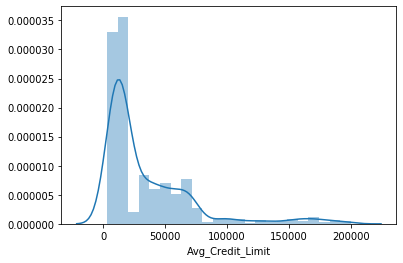

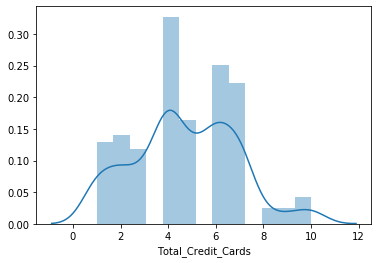

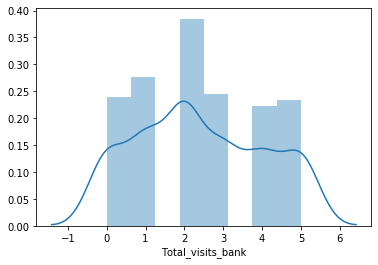

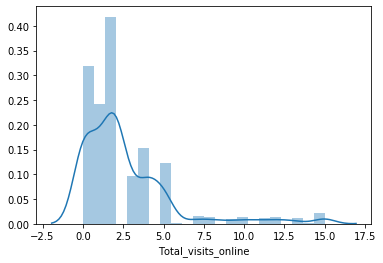

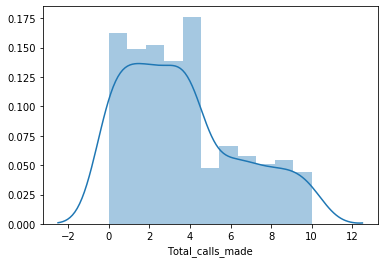

In [178]:
#Distplot
for  col in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'] :
    sns.distplot(CC_DataCleaned_df[col])
    plt.show()

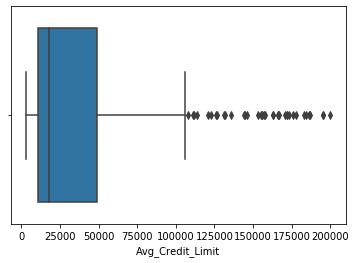

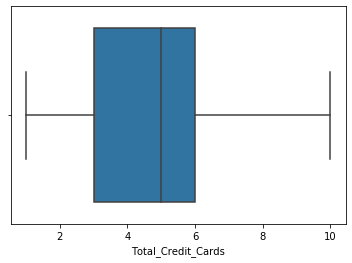

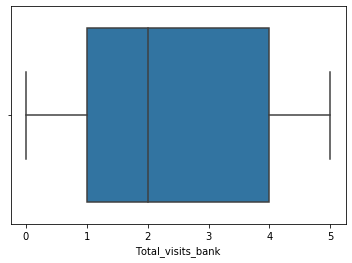

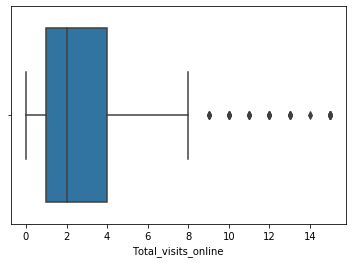

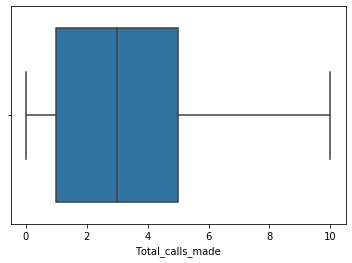

In [179]:
# Boxplot
for  col in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'] :
    sns.boxplot(CC_DataCleaned_df[col])
    plt.show()

### Observations:

    1) Avg_Credit_Limit is positive-skew distributions with lots of outliers.
    2) Total_Credit_Cards looks like has four clusters.
    3) Total_visits_bank show three clusters.
    4) Total_visits_online is also positive-skewed with 3 major distibutions.
    5) Total_calls_made show two cluster.

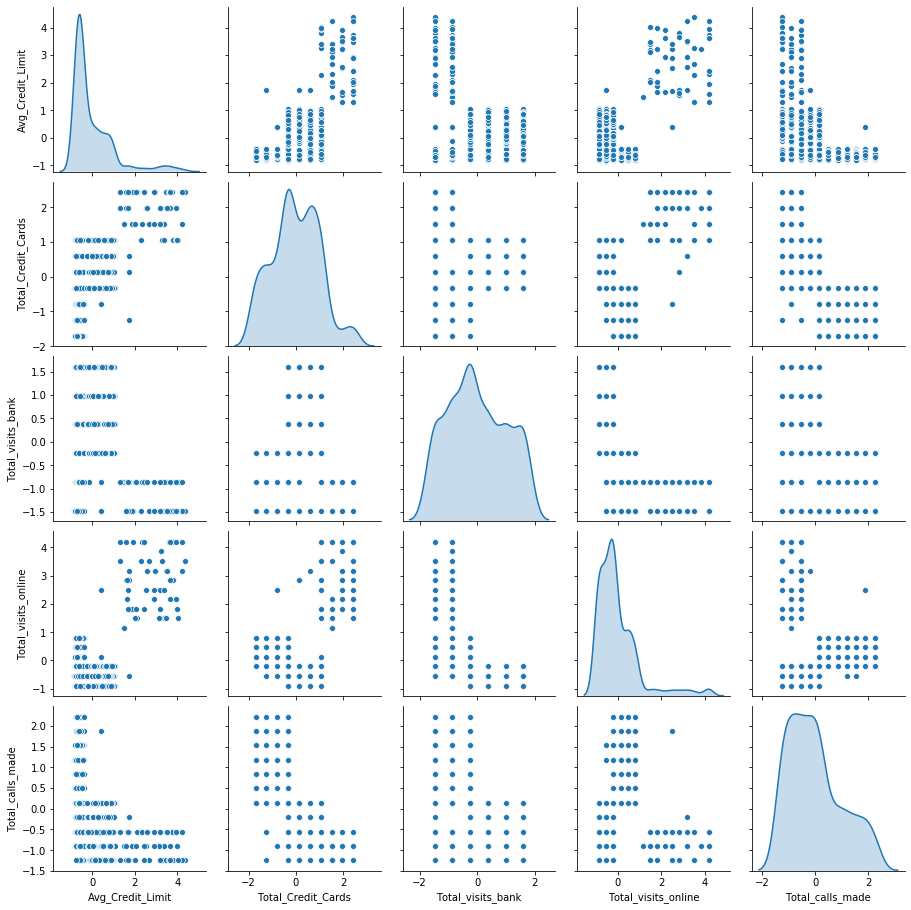

In [180]:
# Scaling
CC_Data_Scaled_df=CC_DataCleaned_df.apply(zscore)
sns.pairplot(CC_Data_Scaled_df,diag_kind='kde')

### Observation:
The above pair plot show around 2-3 clusters for most of the scatter plots.

In [181]:
CC_Data_Scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443
1,0.400209,-0.786701,-1.476410,2.499808,1.881237
2,0.400209,1.054846,-0.860606,0.127419,0.142526
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526
4,1.723499,0.594459,-1.476410,3.177634,-0.205216


##  K-means clustering

Text(0.5, 1.0, 'Elbow Method')

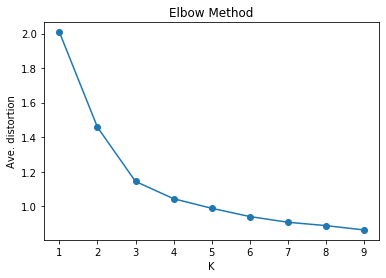

In [182]:
#Finding no. of clusters

clusters=range(1,10)
meanDistortions=[]

for num_clusters in clusters:
    model=KMeans(n_clusters=num_clusters)
    model.fit(CC_Data_Scaled_df)
    prediction=model.predict(CC_Data_Scaled_df)
    meanDistortions.append(sum(np.min(cdist(CC_Data_Scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / CC_Data_Scaled_df.shape[0])


plt.plot(clusters, meanDistortions, marker = "o")
plt.xlabel('K')
plt.ylabel('Ave. distortion')
plt.title('Elbow Method')

Bend is clearly visible at 3. So we will consider 3 clusters

In [183]:
# Let us first start with K = 3
final_model=KMeans(3, random_state=11)
final_model.fit(CC_Data_Scaled_df)
model_prediction=final_model.predict(CC_Data_Scaled_df)

#Append the prediction 
CC_Data_df_KM3 = CC_DataCleaned_df.copy()
CC_Data_Scaled_df_KM3 = CC_Data_Scaled_df.copy()
CC_Data_df_KM3["GROUP"] = model_prediction
CC_Data_Scaled_df_KM3["GROUP"] = model_prediction
print("Groups Assigned : \n")
CC_Data_df_KM3.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2


In [184]:
# silhouette_score

silhouette_avg = silhouette_score(CC_Data_Scaled_df, model_prediction)
print("Average silhoutte score is :", silhouette_avg )

Average silhoutte score is : 0.516281010855363


### Analyze the distribution of the data among the two groups (K = 3). One of the most informative visual tool is boxplot.

In [185]:
CC_Data_Clust_KM3 = CC_Data_df_KM3.groupby(['GROUP'])
CC_Data_Clust_KM3.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403
1,34071.428571,5.518519,3.484127,0.981481,1.992063
2,141040.000000,8.740000,0.600000,10.900000,1.080000


## Boxplot with non scaled Data for K-Means k = 3

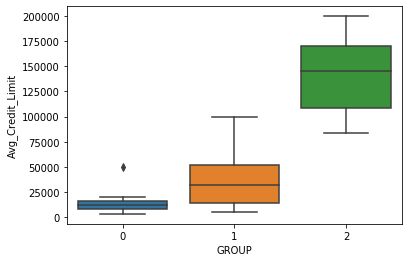

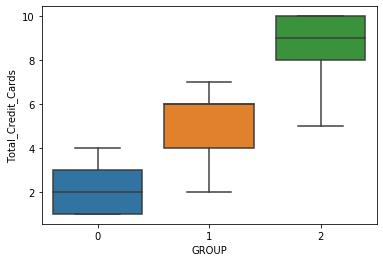

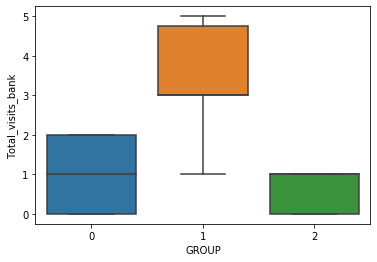

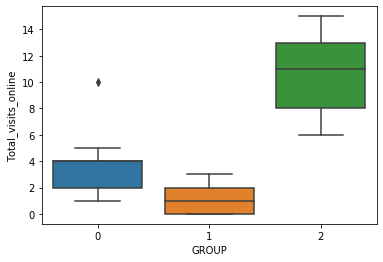

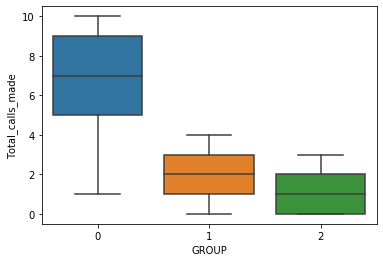

In [186]:
for  col in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'] :
    sns.boxplot(x=CC_Data_df_KM3['GROUP'],y=CC_Data_df_KM3[col])
    plt.show()
    


## Checking performance metrics for Kmeans

    * validating performance with 2 metrics Calinski harabaz and Silhouette score

In [187]:
score={}
score_c={}
CC_Data_df_KM = CC_DataCleaned_df.copy()
CC_Data_Scaled_df_KM = CC_Data_Scaled_df.copy()
for n in range(2,10):
    km_score=KMeans(n_clusters=n, random_state=11)
    km_score.fit(CC_Data_Scaled_df_KM)
    score_c[n]=calinski_harabasz_score(CC_Data_Scaled_df_KM,km_score.labels_)
    score[n]=silhouette_score(CC_Data_Scaled_df_KM,km_score.labels_)

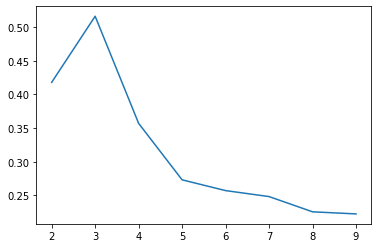

In [188]:
pd.Series(score).plot()

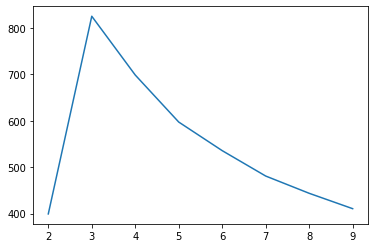

In [189]:
pd.Series(score_c).plot()

### Performance metrics also suggest that K-means with 3 cluster is able to show distinguished characteristics of each cluster.

# Heirachical Clustering

## Method: average

In [190]:
# Using n_clusters = 3

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
model.fit(CC_Data_Scaled_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=3)

In [191]:
CC_Data_df_HC3 = CC_DataCleaned_df.copy()
CC_Data_Scaled_df_HC3 = CC_Data_Scaled_df.copy()

CC_Data_df_HC3['labels'] = model.labels_
CC_Data_Scaled_df_HC3['labels'] = model.labels_
CC_Data_df_HC3.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


In [192]:
#Silhouette_score
silhouette_avg = silhouette_score(CC_Data_Scaled_df,  model.labels_)
print("Average silhoutte score is :", silhouette_avg )

Average silhoutte score is : 0.5164769161012985


In [193]:
CC_Data_Clust_HC3_Ave = CC_Data_df_HC3.groupby(['labels'])
CC_Data_Clust_HC3_Ave.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,34000.000000,5.514512,3.480211,0.984169,1.997361
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12263.636364,2.404545,0.940909,3.568182,6.904545


## Boxplot with non scaled Data for Heirachical Clustering

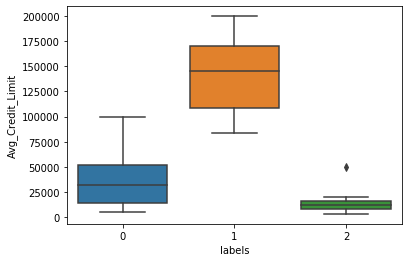

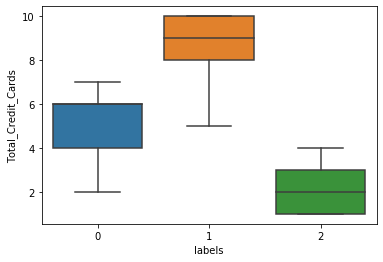

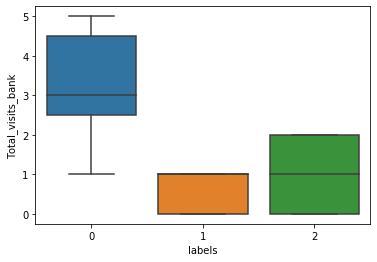

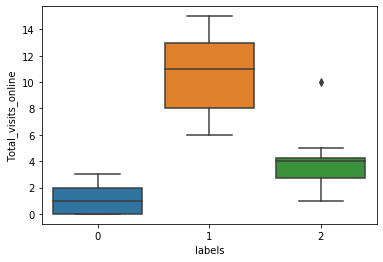

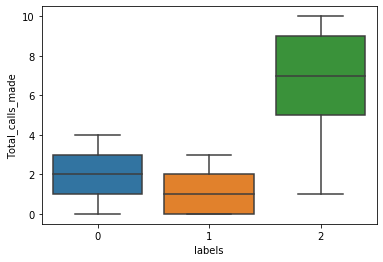

In [194]:
for  col in ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'] :
    sns.boxplot(x=CC_Data_df_HC3['labels'],y=CC_Data_df_HC3[col])
    plt.show()


In [195]:

# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(CC_Data_Scaled_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(CC_Data_Scaled_df))

c

0.8974425535306298

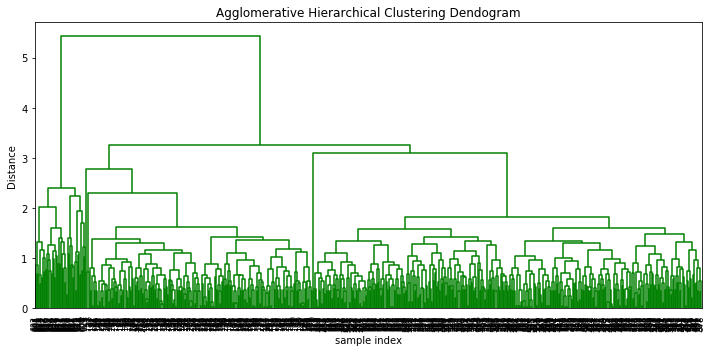

In [196]:
# Full Dendogram

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

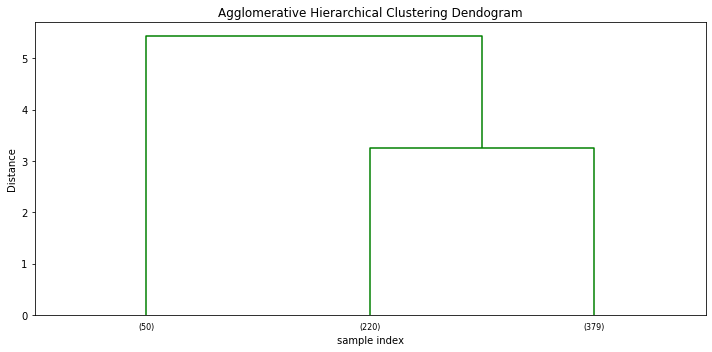

In [197]:
# Truncate at 3 level

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,color_threshold = 40, leaf_font_size=8., truncate_mode='lastp', p=3)
plt.tight_layout()

## Method: complete

In [198]:
model_complete = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete')
model_complete.fit(CC_Data_Scaled_df)

Z = linkage(CC_Data_Scaled_df, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(CC_Data_Scaled_df))

c

0.8794736468795109

In [199]:
silhouette_avg = silhouette_score(CC_Data_Scaled_df,  model_complete.labels_)
print("Average silhoutte score is :", silhouette_avg )

Average silhoutte score is : 0.5158440713805478


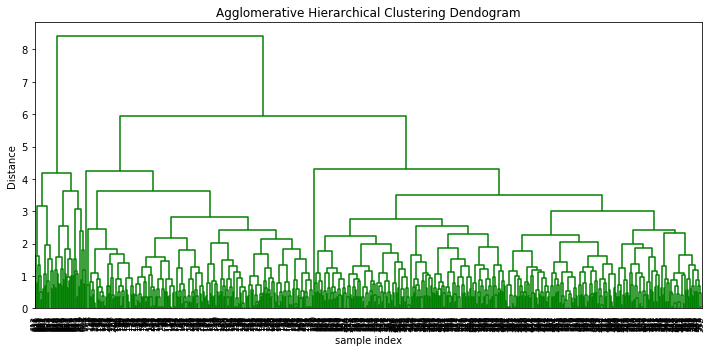

In [200]:
# Full Dendogram

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

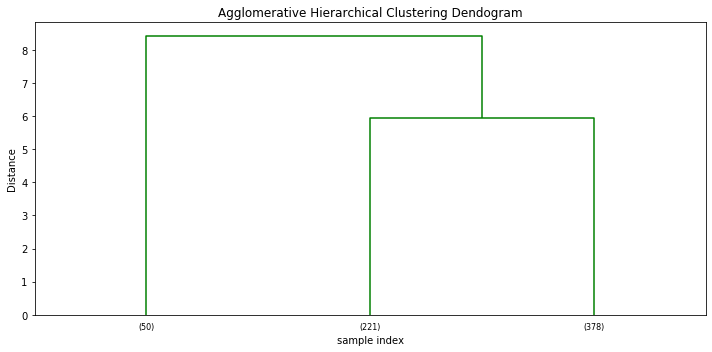

In [201]:
# Truncate at 3 level

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,color_threshold = 40, leaf_font_size=8., truncate_mode='lastp', p=3)
plt.tight_layout()

## Method: ward

In [202]:
model_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')
model_ward.fit(CC_Data_Scaled_df)

Z = linkage(CC_Data_Scaled_df, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(CC_Data_Scaled_df))

c

0.7425813590948763

In [203]:
silhouette_avg = silhouette_score(CC_Data_Scaled_df,  model_ward.labels_)
print("Average silhoutte score is :", silhouette_avg )

Average silhoutte score is : 0.5153242986631665


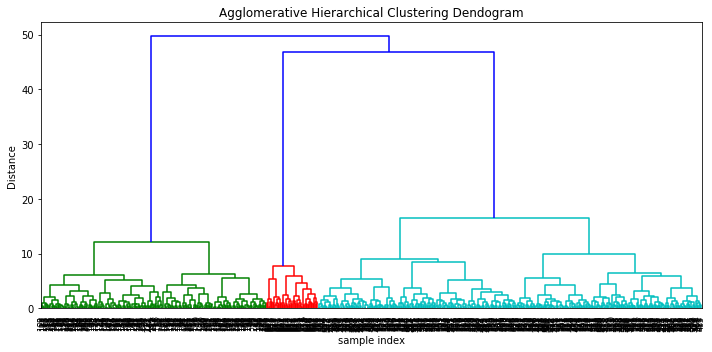

In [204]:
# Full Dendogram

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

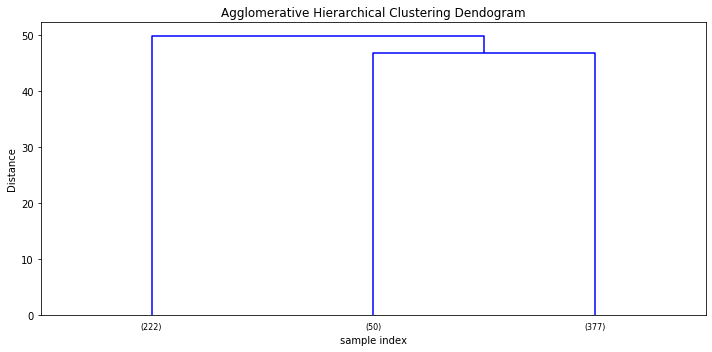

In [205]:
# Truncate at 3 level

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,color_threshold = 40, leaf_font_size=8., truncate_mode='lastp', p=3)
plt.tight_layout()

### Observations related to silhoutte score:   
   
   
    1) For K-Means clustering
        Average silhoutte score is : 0.516281010855363
        
    2) For Hierarchical clustering
        a) Average linkage
            Average silhoutte score is : 0.5164769161012985
            
        b) Complete linkage
            Average silhoutte score is : 0.5158440713805478
            
        c) Ward linkage
            Average silhoutte score is : 0.5153242986631665
            
            
### Here we can see that silhoutte score for Hierarchical clustering with average linkage is best.

In [206]:
# for kMeans clustering with k = 3
CC_Data_Clust_KM3.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403
1,34071.428571,5.518519,3.484127,0.981481,1.992063
2,141040.000000,8.740000,0.600000,10.900000,1.080000


### Obsrvation for KMeans Clustering

We can see for kMeans clustering

Cluster 2 has highest credit limit and they have highest credit cards and do most bussiness online.

Cluster 1 has moderate credit limit and they visit the bank most.

Cluster 0 has lowest credit limit and they make most call to bank.

In [207]:
# for hierarchical clustering with 3 clusters
CC_Data_Clust_HC3_Ave.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,34000.000000,5.514512,3.480211,0.984169,1.997361
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12263.636364,2.404545,0.940909,3.568182,6.904545


### Observation for Average heirarchical clustering:

We can see for Average heirarchical clustering

Cluster 1 has highest credit limit and they have highest credit cards and do most bussiness online.

Cluster 0 has moderate credit limit and they visit the bank most.

Cluster 2 has lowest credit limit and they make most call to bank.

# Conclusion:

    1) Both the clustering methods give similar results
    2) From both models we can see that high credit limit customers tend to use online access to bank more where as low credit limit customer uses call for cummunicating with bank.
    
    So bank can use this finding to better market to various customer. Use online marketing for high credit limit customer 
    and phone for low credit linit customer.   
